In [2]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

ModuleNotFoundError: No module named 'Models'

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

AttributeError: module 'torch._C' has no attribute '_cuda_setDevice'

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(1000))

valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(partial_trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
select = ['act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [6]:
criterion = TripletRegularizedMultiMarginLoss(0, .5)
sess = Session(model, criterion, optim.Adam, 1e-4)

In [7]:
validator = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader), T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [8]:
sess.train(schedule, 31)

Validating: 100%|██████████| 157/157 [00:04<00:00, 32.95it/s]


val accuracy:  0.9738 
train loss:  0.0126  train BCE :  0.4219 
valid loss:  0.0093  valid BCE :  0.2081


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.24it/s]


val accuracy:  0.9825 
train loss:  0.0066  train BCE :  0.1911 
valid loss:  0.0054  valid BCE :  0.1382


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.28it/s]


val accuracy:  0.9885 
train loss:  0.0044  train BCE :  0.1417 
valid loss:  0.0036  valid BCE :  0.1071


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.25it/s]


val accuracy:  0.9909 
train loss:  0.004  train BCE :  0.1153 
valid loss:  0.0031  valid BCE :  0.0899


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.39it/s]


val accuracy:  0.9919 
train loss:  0.0035  train BCE :  0.0934 
valid loss:  0.0026  valid BCE :  0.0704


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.20it/s]


val accuracy:  0.992 
train loss:  0.0017  train BCE :  0.0822 
valid loss:  0.0023  valid BCE :  0.0594


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.14it/s]


val accuracy:  0.9923 
train loss:  0.0022  train BCE :  0.0661 
valid loss:  0.0023  valid BCE :  0.0539


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.34it/s]


val accuracy:  0.9929 
train loss:  0.0017  train BCE :  0.0593 
valid loss:  0.0021  valid BCE :  0.0432


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.14it/s]


val accuracy:  0.9926 
train loss:  0.0019  train BCE :  0.0536 
valid loss:  0.002  valid BCE :  0.0408


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.48it/s]


val accuracy:  0.9938 
train loss:  0.0009  train BCE :  0.0507 
valid loss:  0.0018  valid BCE :  0.0412


Validating: 100%|██████████| 157/157 [00:04<00:00, 33.91it/s]


val accuracy:  0.9948 
train loss:  0.0007  train BCE :  0.0476 
valid loss:  0.0017  valid BCE :  0.0391


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.23it/s]


val accuracy:  0.9938 
train loss:  0.0009  train BCE :  0.0425 
valid loss:  0.0018  valid BCE :  0.0382


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.18it/s]


val accuracy:  0.9943 
train loss:  0.0011  train BCE :  0.0329 
valid loss:  0.0016  valid BCE :  0.0295


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.20it/s]


val accuracy:  0.994 
train loss:  0.0009  train BCE :  0.0316 
valid loss:  0.0017  valid BCE :  0.0288


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.12it/s]


val accuracy:  0.9947 
train loss:  0.0007  train BCE :  0.0313 
valid loss:  0.0015  valid BCE :  0.0309


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.21it/s]


val accuracy:  0.9946 
train loss:  0.0005  train BCE :  0.0265 
valid loss:  0.0017  valid BCE :  0.0236


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.01it/s]


val accuracy:  0.9942 
train loss:  0.0004  train BCE :  0.02 
valid loss:  0.0017  valid BCE :  0.0242


Validating: 100%|██████████| 157/157 [00:04<00:00, 33.96it/s]


val accuracy:  0.9945 
train loss:  0.0004  train BCE :  0.0242 
valid loss:  0.0014  valid BCE :  0.0219


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.15it/s]


val accuracy:  0.9951 
train loss:  0.0002  train BCE :  0.0229 
valid loss:  0.0016  valid BCE :  0.0233


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.45it/s]


val accuracy:  0.9957 
train loss:  0.0004  train BCE :  0.0203 
valid loss:  0.0014  valid BCE :  0.0223


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.38it/s]


val accuracy:  0.9956 
train loss:  0.0005  train BCE :  0.0205 
valid loss:  0.0015  valid BCE :  0.023


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.14it/s]


val accuracy:  0.9952 
train loss:  0.0003  train BCE :  0.0196 
valid loss:  0.0015  valid BCE :  0.0235


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.26it/s]


val accuracy:  0.9954 
train loss:  0.0003  train BCE :  0.0145 
valid loss:  0.0015  valid BCE :  0.0173


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.36it/s]


val accuracy:  0.9949 
train loss:  0.0003  train BCE :  0.0154 
valid loss:  0.0016  valid BCE :  0.0187


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.34it/s]


val accuracy:  0.9953 
train loss:  0.0002  train BCE :  0.0141 
valid loss:  0.0016  valid BCE :  0.0197


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.33it/s]


val accuracy:  0.9952 
train loss:  0.0002  train BCE :  0.0146 
valid loss:  0.0015  valid BCE :  0.0196


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.42it/s]


val accuracy:  0.9949 
train loss:  0.0002  train BCE :  0.016 
valid loss:  0.0017  valid BCE :  0.0212


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.05it/s]


val accuracy:  0.995 
train loss:  0.0001  train BCE :  0.0135 
valid loss:  0.0017  valid BCE :  0.0221


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.43it/s]


val accuracy:  0.9949 
train loss:  0.0001  train BCE :  0.0102 
valid loss:  0.0021  valid BCE :  0.0184


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.35it/s]


val accuracy:  0.9958 
train loss:  0.0001  train BCE :  0.0116 
valid loss:  0.0016  valid BCE :  0.0186


Validating: 100%|██████████| 157/157 [00:04<00:00, 34.53it/s]


val accuracy:  0.9949 
train loss:  0.0003  train BCE :  0.0088 
valid loss:  0.0019  valid BCE :  0.018



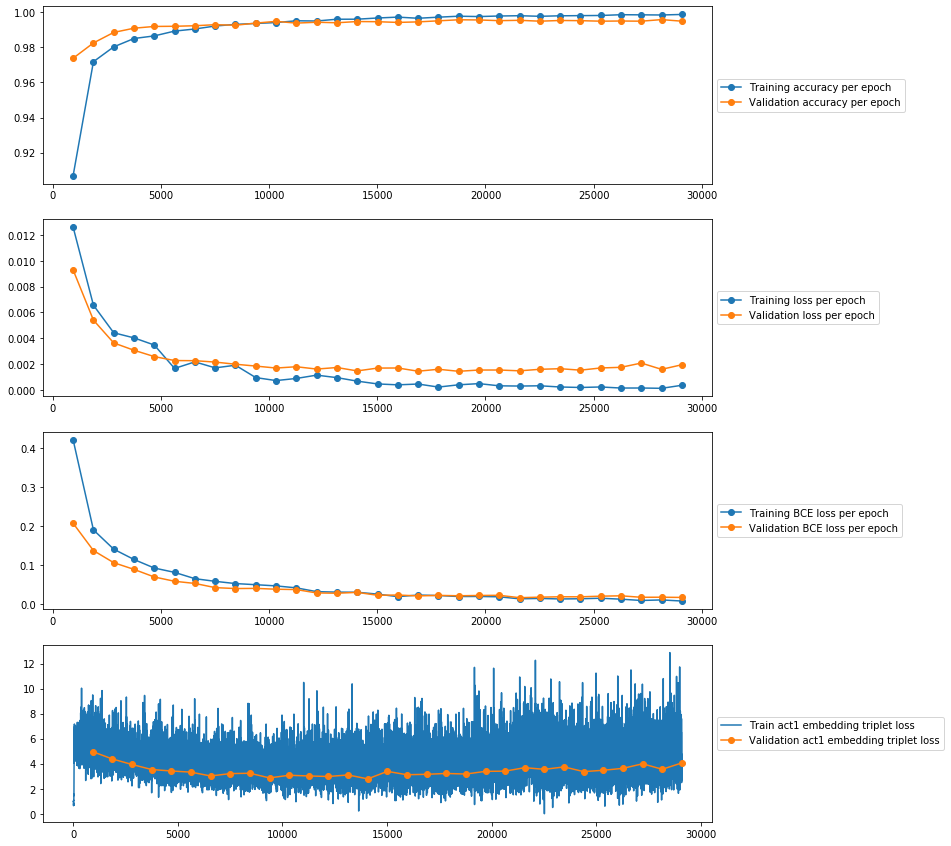

In [9]:
validator.plot()

In [31]:
select = ['act1', 'out']
model2 = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [32]:
criterion = TripletRegularizedMultiMarginLoss(.1, .25)
sess = Session(model2, criterion, optim.Adam, 1e-4)

In [33]:
validator2 = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy)
lr_scheduler = CosAnneal(len(trainloader)*40, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator2])

In [34]:
sess.train(schedule, 40)

Validating: 100%|██████████| 157/157 [00:05<00:00, 28.25it/s]



val accuracy:  0.9892 
train loss:  0.0204  train BCE :  0.8701 
valid loss:  0.0154  valid BCE :  0.6871


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.12it/s]



val accuracy:  0.9926 
train loss:  0.0111  train BCE :  0.573 
valid loss:  0.008  valid BCE :  0.5323


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.84it/s]


val accuracy:  0.9941 
train loss:  0.0065  train BCE :  0.4539 
valid loss:  0.0058  valid BCE :  0.4371


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.00it/s]


val accuracy:  0.9946 
train loss:  0.0066  train BCE :  0.3854 
valid loss:  0.0048  valid BCE :  0.3639


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.08it/s]


val accuracy:  0.9944 
train loss:  0.0037  train BCE :  0.3219 
valid loss:  0.0042  valid BCE :  0.2622


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.33it/s]


val accuracy:  0.9957 
train loss:  0.0025  train BCE :  0.29 
valid loss:  0.0037  valid BCE :  0.2833


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.57it/s]


val accuracy:  0.9953 
train loss:  0.0016  train BCE :  0.2347 
valid loss:  0.0038  valid BCE :  0.1945


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.68it/s]


val accuracy:  0.9949 
train loss:  0.0021  train BCE :  0.2059 
valid loss:  0.0034  valid BCE :  0.1988


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.24it/s]


val accuracy:  0.9954 
train loss:  0.0013  train BCE :  0.2014 
valid loss:  0.0033  valid BCE :  0.1834


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.64it/s]


val accuracy:  0.9952 
train loss:  0.0014  train BCE :  0.1735 
valid loss:  0.0032  valid BCE :  0.1714


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.64it/s]


val accuracy:  0.9956 
train loss:  0.001  train BCE :  0.163 
valid loss:  0.0031  valid BCE :  0.1704


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.57it/s]


val accuracy:  0.9949 
train loss:  0.0008  train BCE :  0.1539 
valid loss:  0.0032  valid BCE :  0.1609


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.63it/s]


val accuracy:  0.9955 
train loss:  0.0007  train BCE :  0.1472 
valid loss:  0.0032  valid BCE :  0.1469


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.13it/s]


val accuracy:  0.9953 
train loss:  0.0005  train BCE :  0.1098 
valid loss:  0.0034  valid BCE :  0.1218


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.29it/s]


val accuracy:  0.9948 
train loss:  0.0008  train BCE :  0.0951 
valid loss:  0.0037  valid BCE :  0.1042


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.11it/s]


val accuracy:  0.9951 
train loss:  0.0005  train BCE :  0.0947 
valid loss:  0.0032  valid BCE :  0.1107


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.34it/s]


val accuracy:  0.995 
train loss:  0.0003  train BCE :  0.0953 
valid loss:  0.0034  valid BCE :  0.0812


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.05it/s]


val accuracy:  0.9951 
train loss:  0.0004  train BCE :  0.0687 
valid loss:  0.003  valid BCE :  0.0921


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.16it/s]


val accuracy:  0.9953 
train loss:  0.0002  train BCE :  0.0812 
valid loss:  0.0033  valid BCE :  0.0841


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.02it/s]


val accuracy:  0.9954 
train loss:  0.0004  train BCE :  0.0879 
valid loss:  0.0031  valid BCE :  0.1035


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.61it/s]


val accuracy:  0.9961 
train loss:  0.0002  train BCE :  0.083 
valid loss:  0.0032  valid BCE :  0.0754


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.15it/s]


val accuracy:  0.9964 
train loss:  0.0002  train BCE :  0.0886 
valid loss:  0.0028  valid BCE :  0.092


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.14it/s]


val accuracy:  0.9956 
train loss:  0.0002  train BCE :  0.0602 
valid loss:  0.0033  valid BCE :  0.062


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.12it/s]


val accuracy:  0.9957 
train loss:  0.0002  train BCE :  0.0713 
valid loss:  0.0031  valid BCE :  0.0912


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.36it/s]


val accuracy:  0.9953 
train loss:  0.0001  train BCE :  0.0474 
valid loss:  0.0035  valid BCE :  0.048


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.01it/s]


val accuracy:  0.9958 
train loss:  0.0001  train BCE :  0.0526 
valid loss:  0.0032  valid BCE :  0.0634


Validating: 100%|██████████| 157/157 [00:05<00:00, 28.74it/s]


val accuracy:  0.9956 
train loss:  0.0001  train BCE :  0.0446 
valid loss:  0.0032  valid BCE :  0.0452


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.99it/s]


val accuracy:  0.9958 
train loss:  0.0001  train BCE :  0.05 
valid loss:  0.0031  valid BCE :  0.0618


Validating: 100%|██████████| 157/157 [00:05<00:00, 29.29it/s]


val accuracy:  0.9957 
train loss:  0.0001  train BCE :  0.0374 
valid loss:  0.0035  valid BCE :  0.0423


Validating: 100%|██████████| 157/157 [00:05<00:00, 30.21it/s]


val accuracy:  0.9963 
train loss:  0.0001  train BCE :  0.0447 
valid loss:  0.0028  valid BCE :  0.0629


Validating: 100%|██████████| 157/157 [00:05<00:00, 31.24it/s]


val accuracy:  0.9963 
train loss:  0.0001  train BCE :  0.0413 
valid loss:  0.003  valid BCE :  0.0451



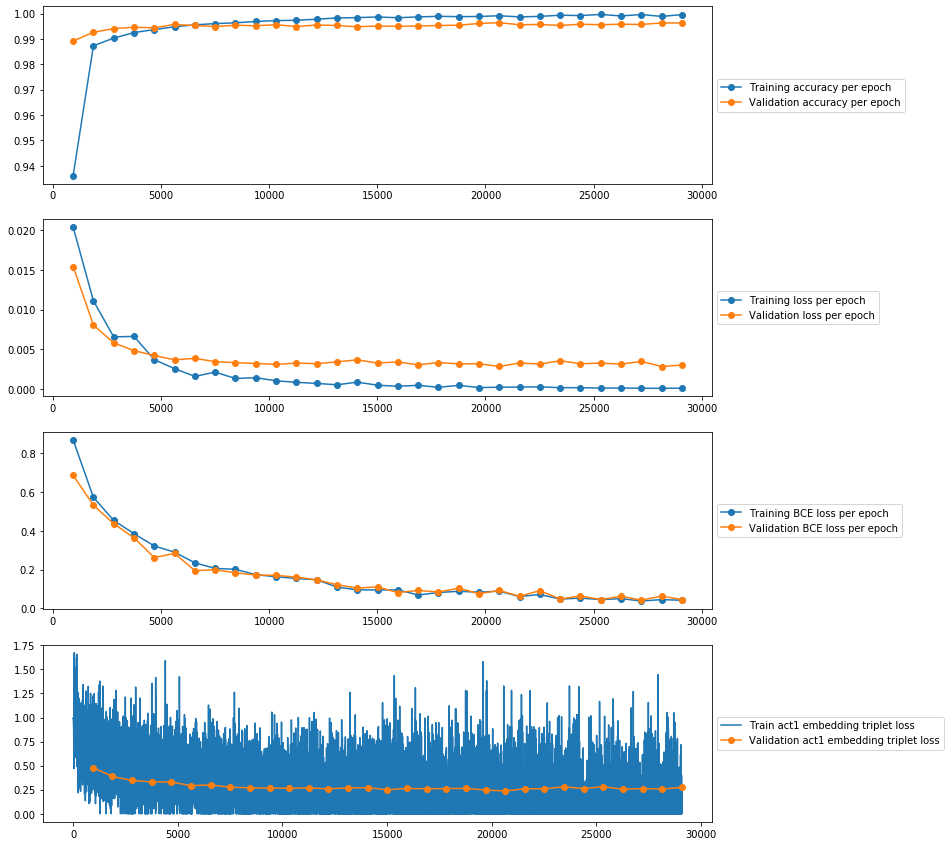

In [35]:
validator2.plot()

In [29]:
np.max(validator2.val_accuracies), "Best accuracy with reg"

(0.9964, 'Best accuracy with reg')

In [30]:
np.max(validator.val_accuracies), "Best accuracy without reg"

(0.9958, 'Best accuracy without reg')

In [17]:
visualization_set = torch.utils.data.dataset.Subset(valset, np.arange(500))
dataloader = torch.utils.data.DataLoader(visualization_set, batch_size=64, shuffle=False)

In [18]:
def tensorboard_embeddings(model, select, dataloader, board='./runs'):
    old_select = model._to_select
    model._to_select = select
    writer = SummaryWriter(board)
    
    outputs = {name: [] for name in select}
    
    with EvalModel(model):
        for input, label in dataloader:
            output = model.forward(Variable(util.to_gpu(input)))
            for layer in output:    
                outputs[layer[1]].append(layer[0].data.cpu().view(layer[0].size(0), -1))    
                
    for name, output in outputs.items():
        cat = torch.cat(output)
        writer.add_embedding(cat, tag=name, metadata=valset.targets[:1000], label_img=1.0 - valset.data[:1000].reshape(-1, 1, 28, 28) / 255.0)

In [19]:
# tensorboard_embeddings(model2, ['max1', 'max3', 'act1', 'act2', 'out'], dataloader, './mnist_layers_reg')

In [20]:
# tensorboard_embeddings(model, ['max3', 'act1', 'act2', 'out'], dataloader, './mnist_layers_noreg')